In [15]:
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(["two", "one", "find"])

# Function for classification
def classify_summary(summary, keyword_dict, synonyms=None, threshold=5):
    summary_lower = summary.lower()
    # Replace synonyms if provided
    if synonyms:
        for syn, replacement in synonyms.items():
            summary_lower = summary_lower.replace(syn, replacement)
    
    score = 0
    for kw, weight in keyword_dict.items():
        count = summary_lower.count(kw)
        if count > 0:
            score += weight * count
    return "Yes" if score >= threshold else "No"

# Function for text cleaning
def clean_text(text, stop_words=None):
    # Remove non-alphanumeric characters and lower text
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords if provided
    if stop_words:
        words = [w for w in text.split() if w not in stop_words]
        return ' '.join(words)
    return text

def analyze_dataset(name, file_path, keyword_dict, synonyms=None, threshold=5):
    # Load dataset
    df = pd.read_csv(file_path)
    
    # Classify summaries
    df["Classification"] = df["Summary"].apply(lambda x: classify_summary(x, keyword_dict, synonyms, threshold))
    
    # Filter WW1 summaries
    Yes_df = df[df["Classification"] == "Yes"]

    # Save only classified as Yes dataset
    yes_output_path = file_path.replace(".csv", "_classified_yes.csv")
    Yes_df.to_csv(yes_output_path, index=False)
    print(f"Filtered dataset with 'Yes' classifications saved to: {yes_output_path}")

    count = (df["Classification"] == "Yes").sum()
    print("Number of movies:", count)
    
    # Combine summaries into one text
    all_Yes_text = " ".join(Yes_df["Summary"].tolist())
    
    # Clean text
    all_YEs_text_clean = clean_text(all_Yes_text, stop_words)
    
    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_YEs_text_clean)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bicubic')
    plt.axis("off")
    plt.title(f"Word Cloud of {name} Summaries")
    plt.show()
    
    # TF-IDF transformation
    vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
    X_tfidf = vectorizer.fit_transform(Yes_df["Summary"].apply(lambda x: clean_text(x, stop_words)))
    
    # LDA for topic modeling
    n_topics = 10
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X_tfidf)
    
    # Print topics
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, component in enumerate(lda.components_):
        top_keywords = [feature_names[i] for i in component.argsort()[:-11:-1]]
        print(f"Topic {topic_idx + 1}: {', '.join(top_keywords)}")
    
    # Save classified dataset
    output_path = file_path.replace(".csv", "_classified.csv")
    df.to_csv(output_path, index=False)
    print(f"Classified dataset saved to: {output_path}")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mattice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Filtered dataset with 'Yes' classifications saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified_yes.csv
Number of movies: 52


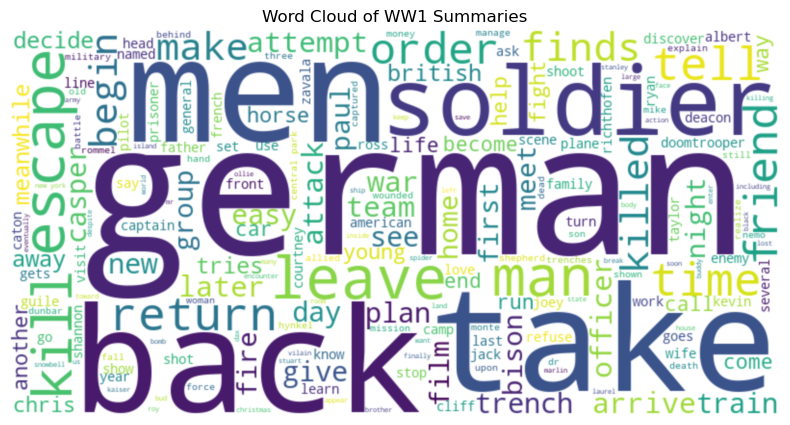

Topic 1: german, soldiers, french, war, men, man, new, escape, central, world
Topic 2: team, ross, shepherd, footage, buddy, kaiser, sub, fort, monte, roy
Topic 3: doomtrooper, dax, hynkel, footage, ice, schultz, mireau, hannah, barber, broulard
Topic 4: stanley, gus, rosie, gnorga, lieutenant, turned, fellow, company, commander, prepares
Topic 5: kevin, courtney, ollie, bison, guile, stan, scott, bisons, brand, pair
Topic 6: hatch, garber, nelson, mike, seaview, sheryl, ida, hijackers, blue, couple
Topic 7: dunbar, spongebob, taylor, joey, zavala, snowbell, stuart, horse, albert, invasion
Topic 8: rommel, richthofen, paul, charlotte, caton, kte, japanese, von, kat, mcclosky
Topic 9: swann, vilain, nemo, benjy, paul, marlin, dory, expendables, kemmerich, kaiser
Topic 10: clouseau, easy, ryan, deacon, beth, sinclair, cliff, rob, rocket, gould
Classified dataset saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified.csv


In [16]:
ww1_keywords = {
    "somme": 3,
    "verdun": 5,
    "trench": 4,
    "ww1": 5,
    "armistice": 2,
    "kaiser": 3,
    "allied": 2,
    "central": 3,
    "frontline": 4,
    "no man's land": 3,
    "mustard_gas": 5,
    "treaty of versailles": 5,
    "mobilization": 2,
    "balkans": 2,
    "zeppelin": 3,
    "shellshock": 4,
    "gallipoli": 4,
    "western front": 5,
    "lusitania": 4
}

synonyms = {
    "first world war": "world war i"
}

analyze_dataset(
    file_path="/Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries.csv",
    keyword_dict=ww1_keywords,
    synonyms=synonyms,
    threshold=7,name = "WW1"
)


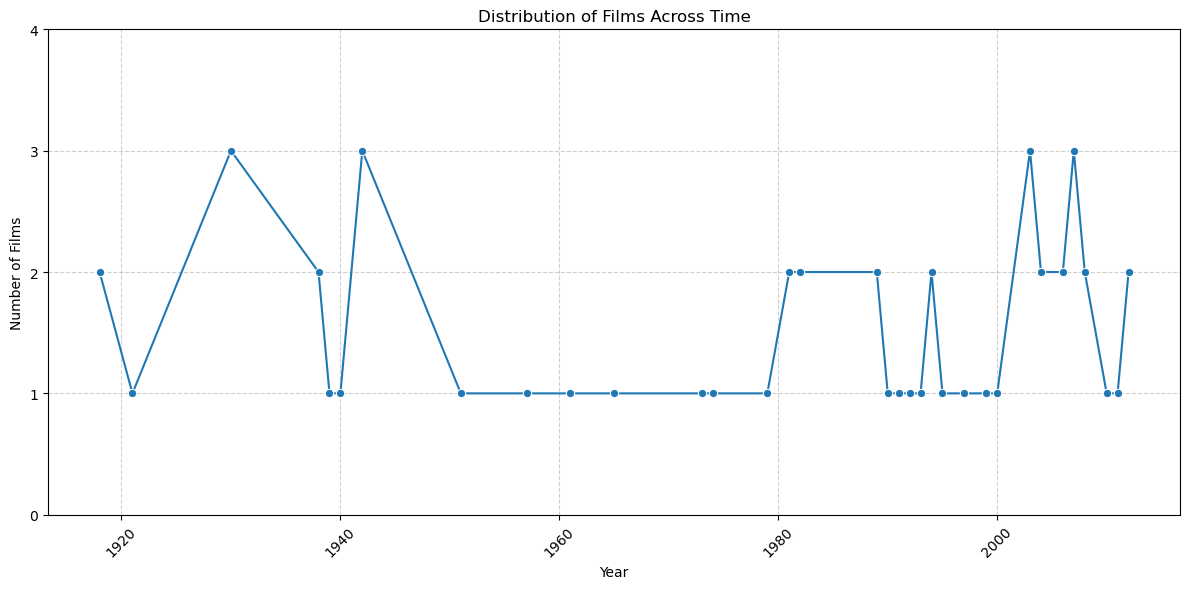

Summary statistics for film years:
count      52.000000
mean     1977.846154
std        29.947264
min      1918.000000
25%      1948.750000
50%      1989.500000
75%      2003.250000
max      2012.000000
Name: Year, dtype: float64


In [17]:
import seaborn as sns
import numpy as np

def analyze_time_distribution(file_path):
    # Load the filtered dataset
    df = pd.read_csv(file_path)
    
   
    # Convert Year column to numeric
    df["Year"] = pd.to_numeric(df["Movie release date"], errors='coerce')
    
    # Drop rows with invalid or missing years
    df = df.dropna(subset=["Year"])
    df["Year"] = df["Year"].astype(int)
    
    # Plot the distribution of films across time
    year_distribution = df.groupby("Year").size().reset_index(name="Count")
    
    # Plot the line plot using Seaborn
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=year_distribution, x="Year", y="Count", marker="o")
    plt.title("Distribution of Films Across Time")
    plt.xlabel("Year")
    plt.ylabel("Number of Films")
    
    # Adjust y-axis to show only integer values
    y_max = year_distribution["Count"].max() + 1
    plt.yticks(np.arange(0, y_max + 1, step=1))
    
    plt.grid(axis='both', linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()
    # Print a summary of the distribution
    print("Summary statistics for film years:")
    print(df["Year"].describe())

# Call the function with the filtered CSV file
filtered_csv_path = "/Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified_yes.csv"
analyze_time_distribution(filtered_csv_path)


Filtered dataset with 'Yes' classifications saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified_yes.csv
Number of movies: 25


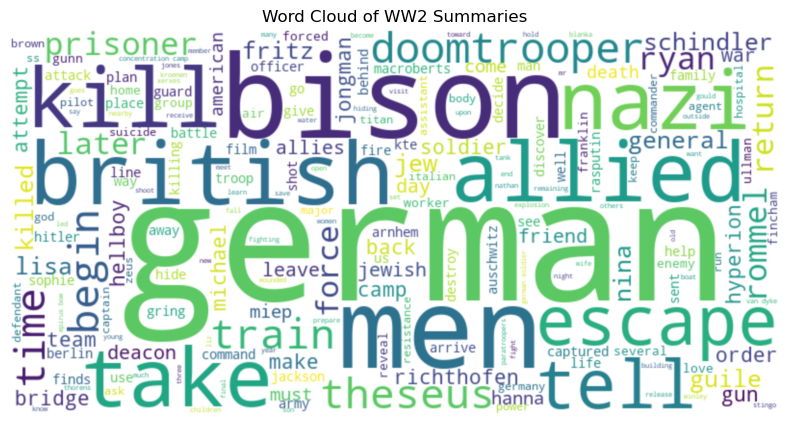

Topic 1: rommel, michael, miep, theseus, guile, bison, children, mr, hanna, auschwitz
Topic 2: island, patrol, message, allied, successful, landing, frank, information, alive, french
Topic 3: doomtrooper, gring, jackson, team, malloy, speer, gilbert, crimes, jones, german
Topic 4: taking, situation, killed, arrives, death, eventually, away, meets, later, forced
Topic 5: richthofen, ryan, train, kte, von, fincham, voss, italian, brown, prisoners
Topic 6: schindler, gunn, water, factory, jews, germans, goeth, workers, schindlers, stern
Topic 7: jongman, van, lisa, dyke, prisoners, mallory, franklin, auschwitz, leatherby, guns
Topic 8: macroberts, arnhem, general, bridge, paratroopers, british, bartlett, xxx, browning, men
Topic 9: sophie, stingo, nathan, children, camp, father, make, auschwitz, sent, gestapo
Topic 10: hellboy, nina, deacon, fritz, xerxes, leonidas, rasputin, allies, right, winley
Classified dataset saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/

In [18]:
ww2_keywords = {
    "allies": 3, "allied": 3, "auschwitz": 5
}
analyze_dataset(
    file_path="/Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries.csv",
    keyword_dict=ww2_keywords,
    synonyms=synonyms,
    threshold=7,name="WW2"
)

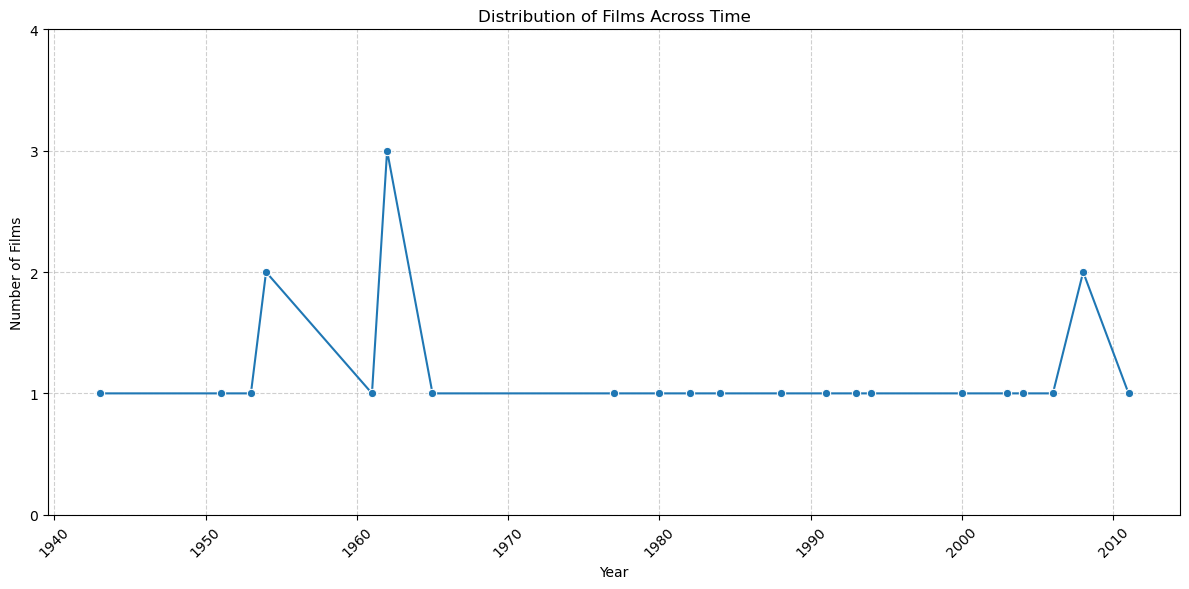

Summary statistics for film years:
count      25.000000
mean     1979.840000
std        21.541975
min      1943.000000
25%      1962.000000
50%      1982.000000
75%      2000.000000
max      2011.000000
Name: Year, dtype: float64


In [19]:
analyze_time_distribution(filtered_csv_path)

Filtered dataset with 'Yes' classifications saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified_yes.csv
Number of movies: 200


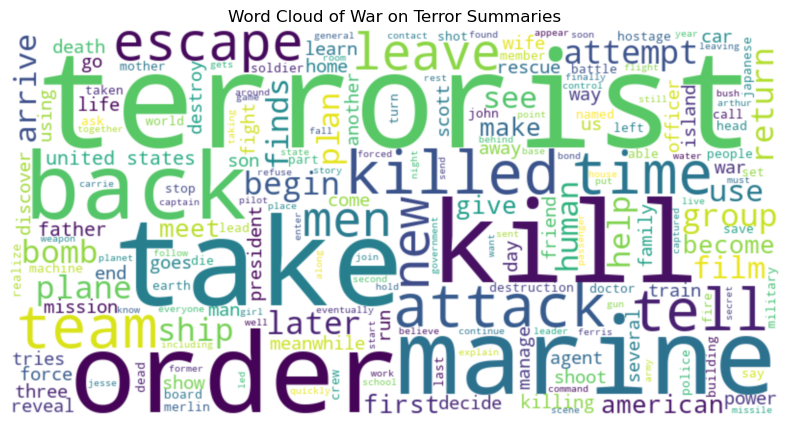

Topic 1: stark, village, company, events, wounded, missile, building, device, weapons, rescued
Topic 2: ryback, colony, harry, sarah, doctor, interview, village, anthony, ships, train
Topic 3: terrorist, terrorists, bomb, group, new, time, world, wife, dr, home
Topic 4: garber, hassan, cris, saigo, held, want, escapes, ferris, terrorists, terrorist
Topic 5: craig, pike, doctor, anthony, merlin, ryder, stavros, goodspeed, quinn, mason
Topic 6: marines, team, president, plane, japanese, war, men, united, states, mission
Topic 7: bob, stone, izzy, harold, caton, matrix, village, tell, situation, start
Topic 8: village, caspian, jesse, ferris, carrie, edy, anna, sarah, stone, light
Topic 9: bridger, faraday, arthur, jonn, ferris, harry, centre, doctor, quinn, anthony
Topic 10: kong, cabot, oskar, cavil, sarge, reaper, 11, intelligence, working, leader
Classified dataset saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified.csv


In [20]:

W991_keywords = {
    "september 11 attacks": 5,
    "twin towers": 5,
    "world trade center": 5,
    "wtc": 4,
    "terrorist": 5,
    "al-qaeda": 5,
    "hijackers": 4,
    "boeing 767": 3,
    "destruction": 4,
    "osama bin laden": 5,
    "afghanistan": 3,
    "invasion": 2,
    "irak": 2,
    "marines": 3
}
analyze_dataset(
    file_path="/Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries.csv",
    keyword_dict=W991_keywords,
    synonyms=synonyms,
    threshold=7,name="War on Terror"
)

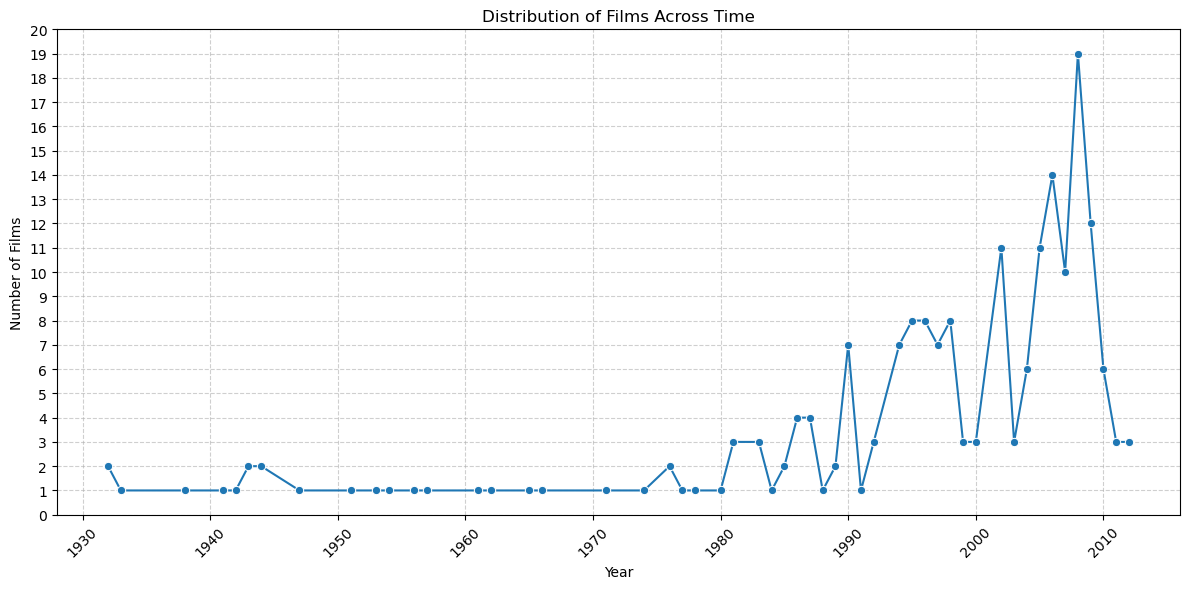

Summary statistics for film years:
count     200.000000
mean     1994.480000
std        18.076043
min      1932.000000
25%      1990.000000
50%      2000.000000
75%      2007.000000
max      2012.000000
Name: Year, dtype: float64


In [21]:
analyze_time_distribution(filtered_csv_path)

Filtered dataset with 'Yes' classifications saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified_yes.csv
Number of movies: 24


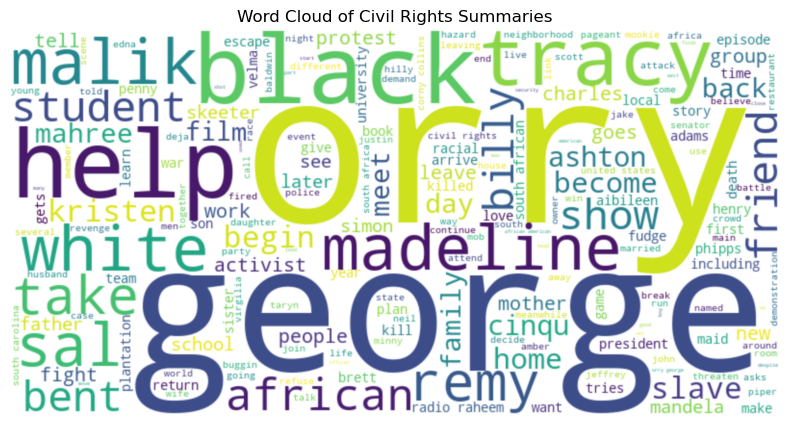

Topic 1: henry, mariah, sheyann, tracy, justin, kerry, anthony, senator, march, rights
Topic 2: simon, odessa, tiananmen, skeeter, miriam, aibileen, book, minny, cultural, 1989
Topic 3: disabilities, worth, activists, public, living, lives, including, rights, demand, discrimination
Topic 4: sal, radio, raheem, mookie, sals, neighborhood, pino, buggin, crowd, restaurant
Topic 5: africans, neil, growth, rats, cinqu, adams, amistad, serum, dean, bobby
Topic 6: evers, orry, mississippi, boone, yoast, titans, george, madeline, team, game
Topic 7: songs, south, apartheid, freedom, music, film, africa, rights, african, abolitionist
Topic 8: tracy, malik, remy, kristen, edna, link, phipps, pageant, velma, wilbur
Topic 9: mahree, protesters, protest, movie, south, began, dellums, world, police, situation
Topic 10: jake, jeffrey, bus, mandela, springboks, network, boycott, maniac, south, mandelas
Classified dataset saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processe

In [22]:
rights_keywords = {
    "segregation": 7,
    "civil rights": 6,
    "Martin Luther King": 5,
    "protest": 4,
    "racial": 5,
    "integration": 5,
    "discrimination": 6,
    "abolition": 6,
    "boycott": 4,
    "Rosa Parks": 5,
    "sit-in": 5,
    "nonviolence": 4,
    "Jim Crow": 7,
    "oppression": 5,
    "voting rights": 6,
    "demonstration": 4,
    "march on Washington": 7,
    "Montgomery": 5,
    "Selma": 6,
    "Black Power": 5,
    "NAACP": 6,
    "activist": 4,
    "white supremacy": 7,
    "emancipation": 6,
    "equality act": 5,
    "racial harmony": 4,
    "abolitionist": 5,
    "fair housing": 4,
    "education rights": 4,
    "equal opportunity": 5,
    "freedom riders": 6,
    "lynching": 7,
    "abolition movement": 6,

}

analyze_dataset(
    file_path="/Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries.csv",
    keyword_dict=rights_keywords,
    synonyms=synonyms,
    threshold=20,name="Civil Rights"
)


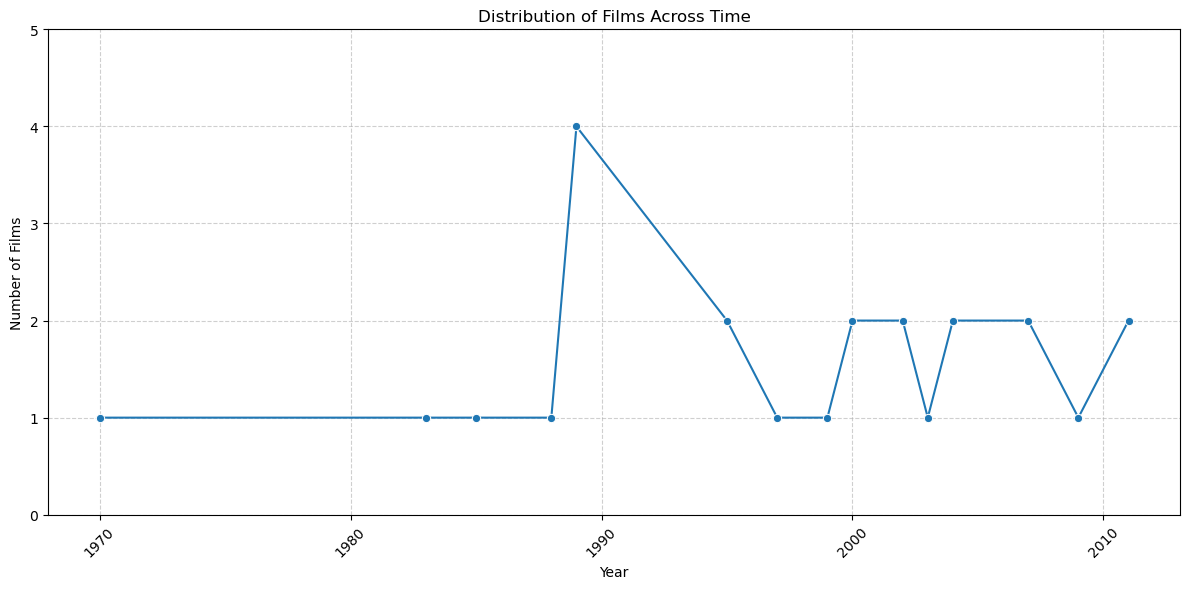

Summary statistics for film years:
count      24.000000
mean     1997.000000
std        10.121007
min      1970.000000
25%      1989.000000
50%      1999.500000
75%      2004.000000
max      2011.000000
Name: Year, dtype: float64


In [23]:
analyze_time_distribution(filtered_csv_path)

Filtered dataset with 'Yes' classifications saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified_yes.csv
Number of movies: 801


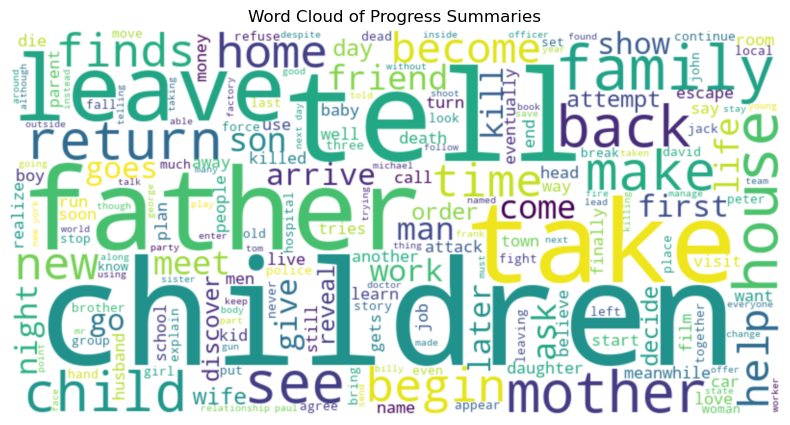

Topic 1: emily, andy, peter, jesus, jimmy, god, military, lost, paul, deal
Topic 2: children, child, family, father, house, home, mother, tells, new, film
Topic 3: stanley, adam, park, charlie, boat, david, nick, enter, changes, ray
Topic 4: fred, emma, smith, edward, peter, machine, laura, boss, better, birthday
Topic 5: walter, near, park, street, accepts, true, apartment, knows, kevin, chance
Topic 6: alice, ben, jason, freddy, richard, tom, jesus, andy, dan, dream
Topic 7: charlie, bruce, chris, charles, jenny, fred, emily, dan, factory, leads
Topic 8: nick, information, baby, apartment, sex, sarah, affair, dr, making, future
Topic 9: jenny, andy, class, book, dance, paul, professor, david, james, follows
Topic 10: jesus, andy, freddy, jenny, fred, charlie, emily, emma, laura, edward
Classified dataset saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified.csv


In [24]:
Progress = {
    "reform": 5,
    "progressive": 4,
    "industrial": 3,
    "suffrage": 4,
    "labor": 3,
    "union": 4,
    "factory": 3,
    "child": 4,  # Related to child labor reform
    "education": 3,
    "worker": 3,
    "strike": 4,
    "social": 3,
    "temperance": 3,  # Related to anti-alcohol movements
    "prohibition": 4,
    "women vote": 4,  # Related to suffrage and labor movements
    "equality": 3,
    "tenement": 3,  # Related to urban housing reform
    "corruption": 4,  # Related to political reform
    "muckraker": 4,  # Journalists exposing corruption
    "roosevelt": 4,  # Referring to President Theodore Roosevelt
    "justice": 4,
    "equity": 3,
    "change": 3,  # General term for reform movements
    "poverty": 4,  # Highlighting poor urban conditions
}

analyze_dataset(
    file_path="/Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries.csv",
    keyword_dict=Progress,
    synonyms=synonyms,
    threshold=16,name="Progress"
)

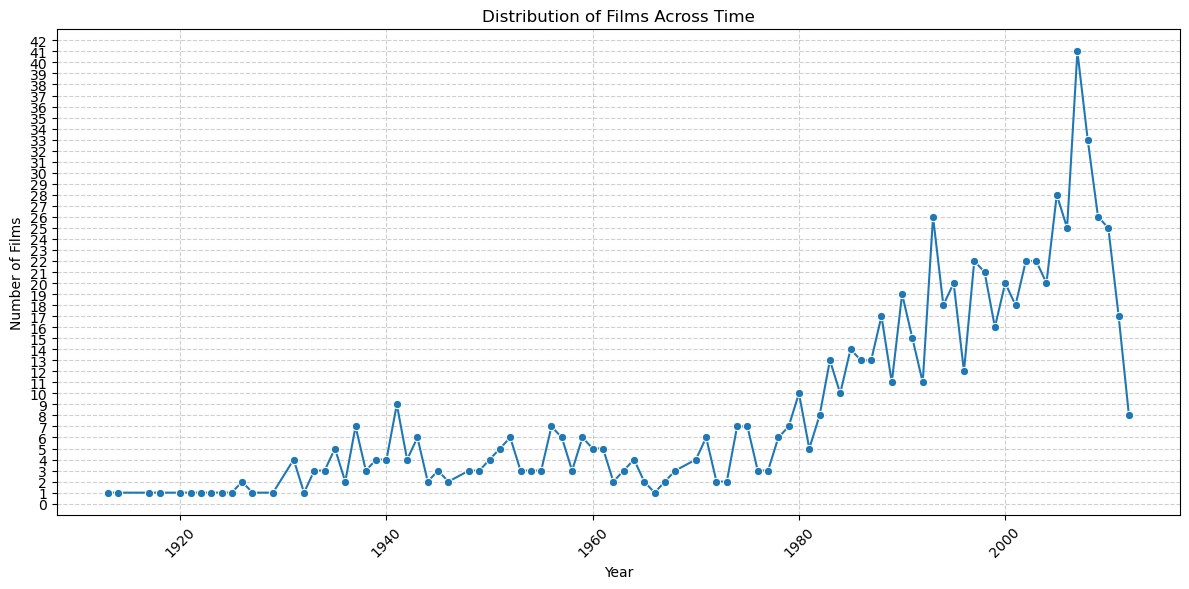

Summary statistics for film years:
count     801.000000
mean     1987.111111
std        22.674025
min      1913.000000
25%      1979.000000
50%      1994.000000
75%      2005.000000
max      2012.000000
Name: Year, dtype: float64


In [25]:
analyze_time_distribution(filtered_csv_path)

Filtered dataset with 'Yes' classifications saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified_yes.csv
Number of movies: 41


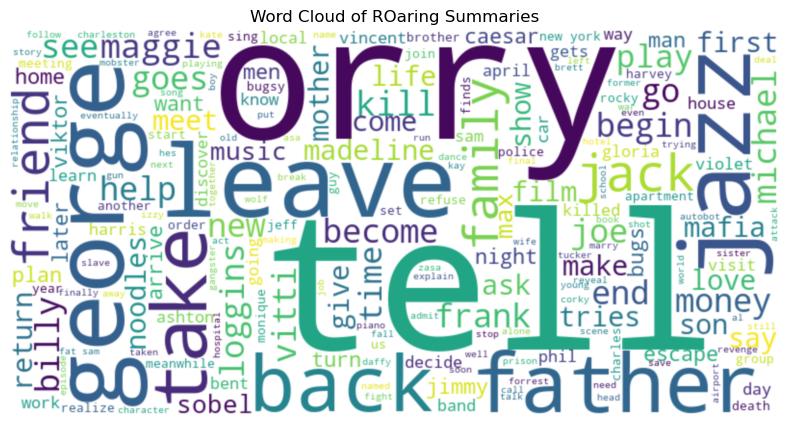

Topic 1: jack, mafia, joe, frank, father, new, tells, charleston, max, family
Topic 2: izzy, autobots, allspark, celia, sam, love, musical, producer, van, horn
Topic 3: tucker, billy, phyllis, automobile, dream, company, helps, makes, airport, secret
Topic 4: loggins, bugs, wolf, forrest, rakes, rocky, daffy, harris, mugsy, monique
Topic 5: viktor, finch, george, april, owl, morgan, explains, airport, horn, dixon
Topic 6: noodles, punisher, joe, scene, jazz, quickly, say, hit, player, playing
Topic 7: harvey, jeff, fat, jazz, orleans, guy, bugsy, plot, mafia, faye
Topic 8: owl, sing, instead, jazz, young, gang, german, seen, best, plot
Topic 9: michael, caesar, vincent, violet, corky, zasa, johnnie, gino, altobello, mary
Topic 10: kate, jazz, maggie, vitti, mike, orry, sobel, club, know, tony
Classified dataset saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified.csv


In [ ]:
Roaring = {
    "jazz": 8,
    "flapper": 6,
    "prohibition": 5,
    "speakeasy": 5,
    "roaring": 4,
    "gatsby": 4,
    "bootlegger": 5,
    "art deco": 3,
    "charleston": 4,
    "stock market": 5,
    "prohibitionist": 3,
    "mafia": 4,
    "automobile": 4,
    "consumerism": 3,
}


analyze_dataset(
    file_path="/Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries.csv",
    keyword_dict=Roaring,
    synonyms=synonyms,
    threshold=16,name="Roaring Twenties"
)

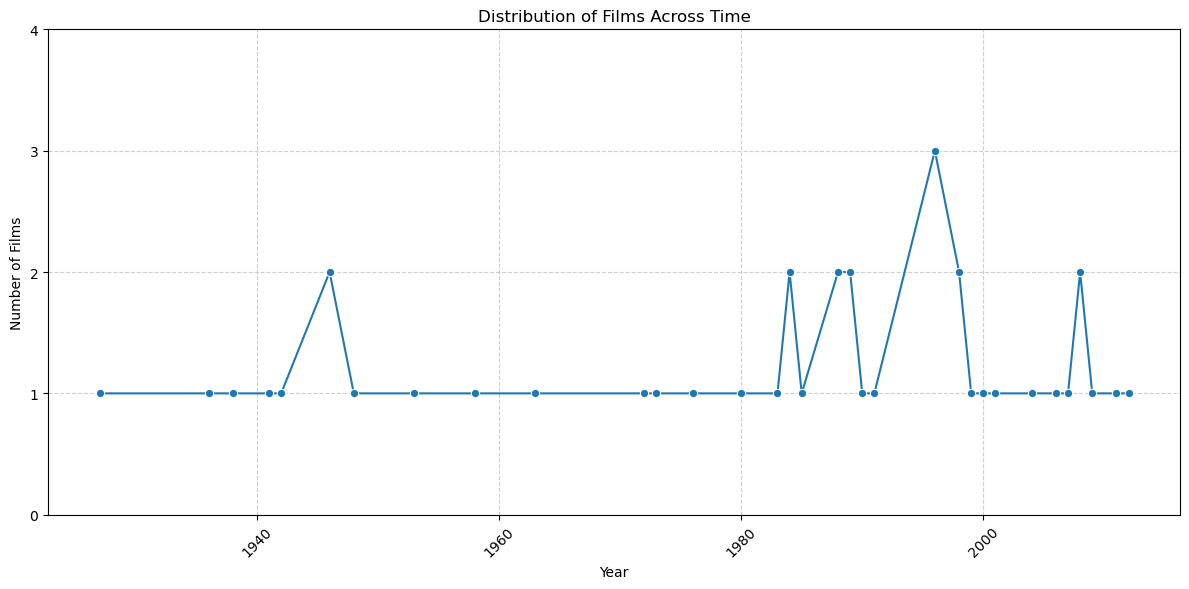

Summary statistics for film years:
count      41.000000
mean     1980.951220
std        24.481576
min      1927.000000
25%      1963.000000
50%      1988.000000
75%      1999.000000
max      2012.000000
Name: Year, dtype: float64


In [27]:
analyze_time_distribution(filtered_csv_path)

Filtered dataset with 'Yes' classifications saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified_yes.csv
Number of movies: 46


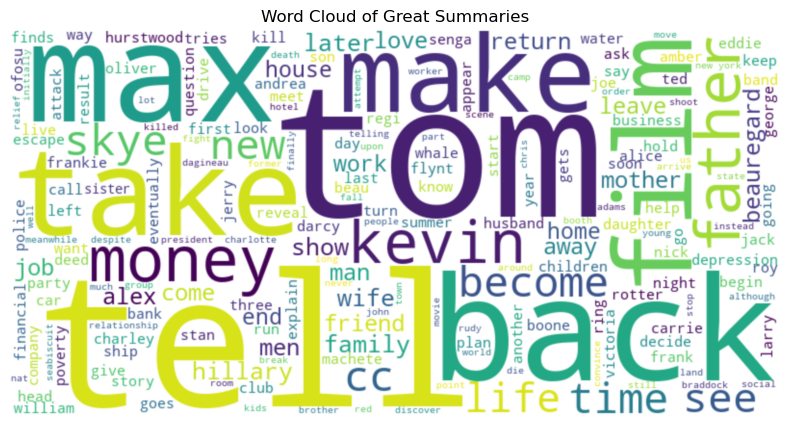

Topic 1: charley, dodd, joe, greek, migrant, pete, nick, family, fortune, camp
Topic 2: poverty, regi, westlake, dorothy, ted, jack, caroline, eddie, frank, world
Topic 3: boone, whale, carrie, hurstwood, adams, alice, mr, drouet, lamb, russell
Topic 4: tom, frankie, senga, wife, summer, land, store, bowl, jerry, immigrant
Topic 5: william, president, office, andrea, charlotte, alice, depression, chris, nick, true
Topic 6: machete, beau, children, idaho, howard, dagineau, national, red, horse, seabiscuit
Topic 7: george, skye, kevin, linda, lennie, max, clown, alex, oliver, dream
Topic 8: beauregard, cc, hillary, banks, cdos, waters, investment, financial, ratings, victoria
Topic 9: deeds, marsh, braddock, baer, cedar, financial, success, hand, ring, street
Topic 10: flynt, darcy, frank, stan, rudy, father, steves, roy, luke, class
Classified dataset saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified.csv


In [ ]:
GreatDepression = {
    "depression": 8,
    "poverty": 7,
    "unemployment": 7,
    "dust bowl": 6,
    "hooverville": 5,
    "bankruptcy": 6,
    "soup kitchen": 5,
    "new deal": 7,
    "recession": 5,
    "foreclosure": 4,
    "stock market crash": 7,
    "migrant": 4,
    "relief": 5,
    "hardship": 4,
    "recovery": 4,
}


analyze_dataset(
    file_path="/Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries.csv",
    keyword_dict = GreatDepression,
    synonyms=synonyms,
    threshold=14,name="Great Depression"
)

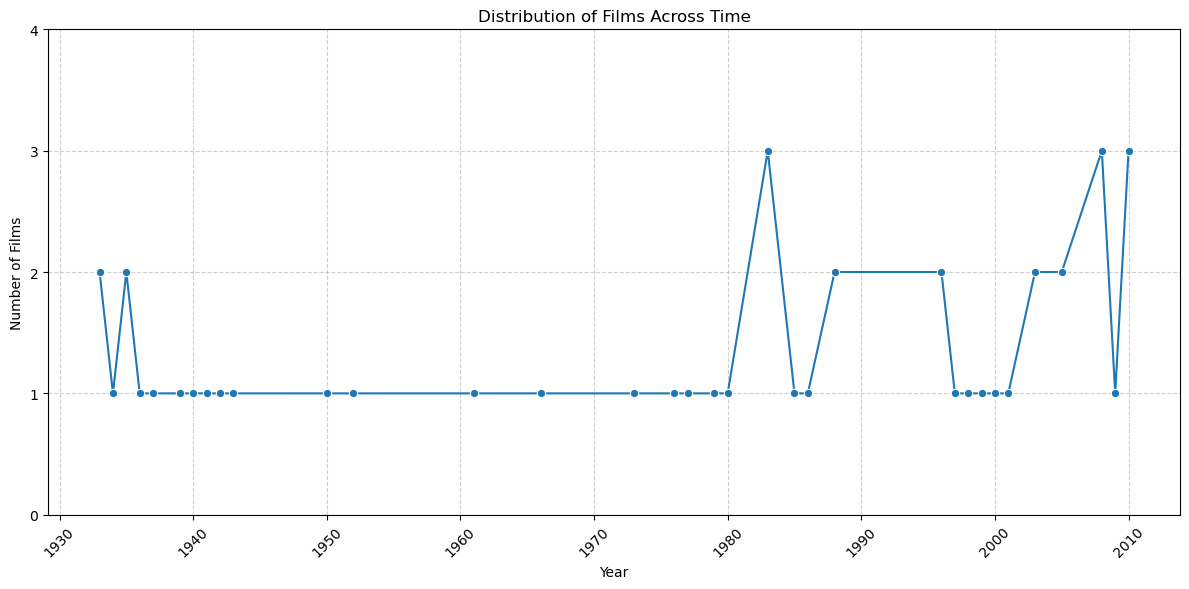

Summary statistics for film years:
count      46.000000
mean     1976.608696
std        27.694747
min      1933.000000
25%      1944.750000
50%      1983.000000
75%      2000.750000
max      2010.000000
Name: Year, dtype: float64


In [29]:
analyze_time_distribution(filtered_csv_path)

Filtered dataset with 'Yes' classifications saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified_yes.csv
Number of movies: 258


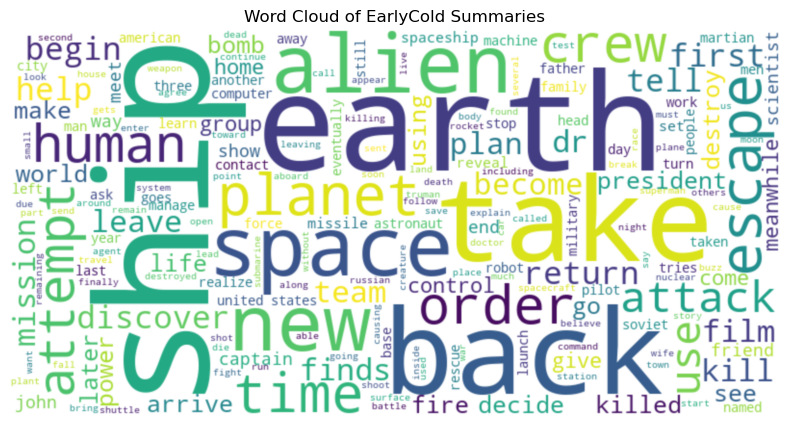

Topic 1: space, earth, ship, nuclear, dr, planet, alien, crew, film, new
Topic 2: buzz, ref, darkrai, ash, marlene, square, woody, town, battle, technology
Topic 3: harry, max, bugs, hal, jimmy, tim, fritz, martin, martian, mars
Topic 4: terrorists, martians, ben, martian, mars, peter, jim, cale, klaatu, vostrikov
Topic 5: billy, chuck, frank, mr, bond, jack, shoot, runs, meet, desert
Topic 6: jerry, adam, leo, helen, marnie, square, peter, asteroid, tom, apes
Topic 7: george, snow, dominic, frank, superman, harry, mr, asteroid, alex, prison
Topic 8: superman, mr, flynn, bond, square, george, jerry, jones, martians, christmas
Topic 9: truman, jones, woody, buzz, mars, mr, george, adam, soviets, truck
Topic 10: ripley, frank, asteroid, clutch, marlene, george, bond, ash, mr, truman
Classified dataset saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified.csv


In [ ]:
EarlyColdWar = {
    "communism": 8,
    "atomic": 7,
    "space": 6,
    "red scare": 5,
    "sputnik": 5,
    "mccarthyism": 5,
    "nuclear": 6,
    "arms race": 6,
    "iron curtain": 5,
    "truman": 4,
    "containment": 4,
    "berlin airlift": 5,
    "proxy war": 4,
    "espionnage":5
}

analyze_dataset(
    file_path="/Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries.csv",
    keyword_dict = EarlyColdWar,
    synonyms=synonyms,
    threshold=16,name="Cold"
)

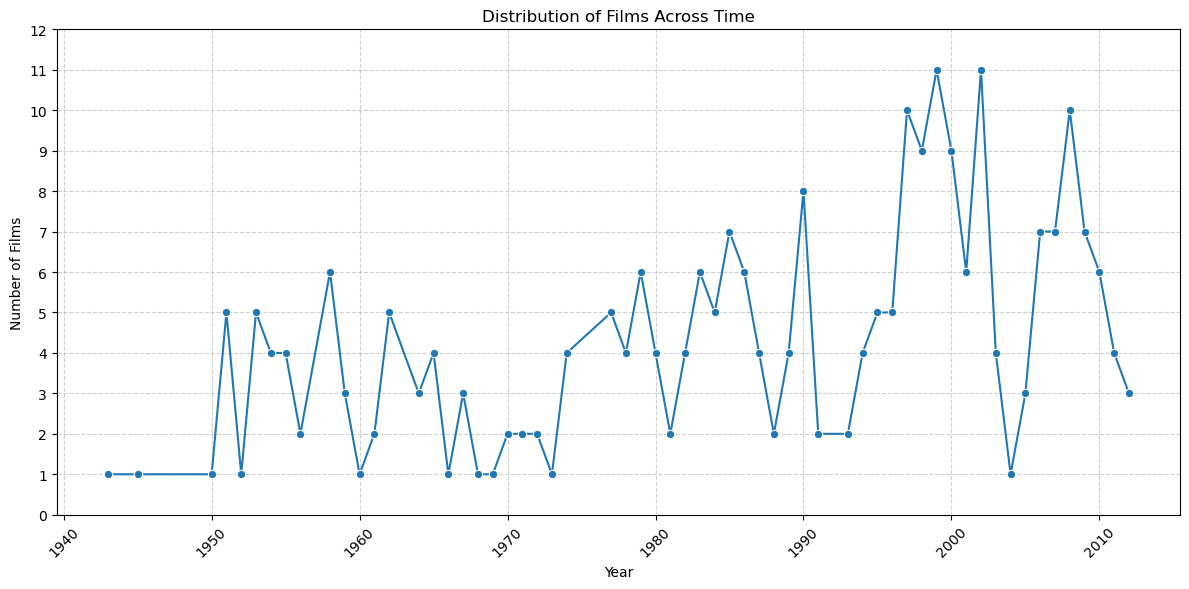

Summary statistics for film years:
count     258.000000
mean     1986.856589
std        18.107085
min      1943.000000
25%      1974.750000
50%      1990.000000
75%      2001.000000
max      2012.000000
Name: Year, dtype: float64


In [31]:
analyze_time_distribution(filtered_csv_path)

Filtered dataset with 'Yes' classifications saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified_yes.csv
Number of movies: 204


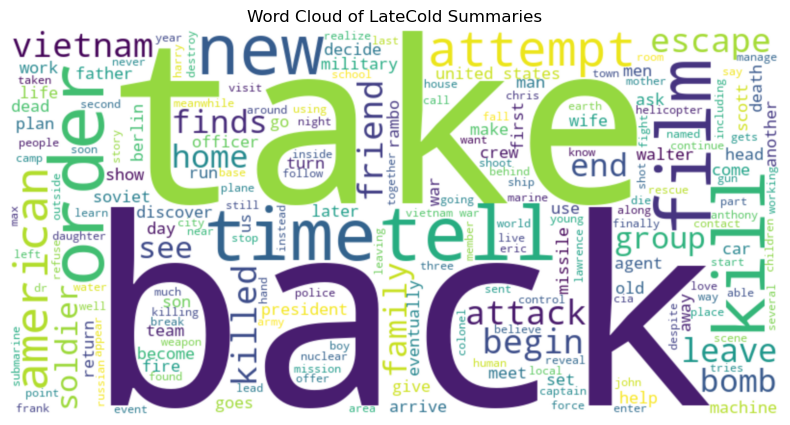

Topic 1: kate, bourne, eric, daniel, miyagi, karl, scott, informs, river, mike
Topic 2: bozz, caldwell, austin, driver, window, lost, member, lawrence, learn, squad
Topic 3: rambo, billy, jake, river, lost, college, fall, station, stay, bar
Topic 4: general, veteran, hunt, gang, lawrence, george, terminator, richie, terrorists, kyle
Topic 5: scott, murtaugh, ralph, arrive, general, driver, heads, learn, window, college
Topic 6: max, anthony, cris, leatherface, helen, eric, heads, window, arrive, george
Topic 7: taylor, viet, cong, squad, platoon, mac, village, enemy, sergeant, heads
Topic 8: frank, van, dominic, mike, otto, chris, walter, drug, vietnam, veteran
Topic 9: alien, novel, bond, station, main, kate, computer, submarine, rest, squad
Topic 10: vietnam, nuclear, war, film, american, new, vietnamese, states, president, bomb
Classified dataset saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified.csv


In [ ]:
LateColdWar = {
    "vietnam": 8,
    "nuclear": 7,
    "detente": 5,
    "berlin": 6,
    "protest": 6,
    "afghanistan": 5,
    "cold war": 6,
    "reagan": 6,
    "glasnost": 5,
    "sandinista": 4,
    "proxy conflict": 4,
    "peace talks": 4,
    "iran contra": 4,
    "protest":2
}
analyze_dataset(
    file_path="/Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries.csv",
    keyword_dict = LateColdWar,
    synonyms=synonyms,
    threshold=16,name="Late Cold War"
)

In [33]:
df = pd.read_csv("/Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified.csv")

# Filter rows where the 'Classification' column has "Yes"
filtered_rows = df[df["Classification"] == "Yes"]

# Print the filtered rows
filtered_rows.head()

Wikipedia movie ID                                            Summary  \
12             15224586  The film follows the experience of Vietnamese ...   
123            20887118  {{long plot}} The opening scenes of The Plan o...   
140             7171361  Joseph Megessey  is a Vietnam war veteran suff...   
204             4370892  Roger Cobb , an author of horror novels, is a ...   
419             8536802  Sniper Thomas Beckett  is hired by NSA officia...   

     Movie release date Classification  
12                 2001            Yes  
123                2009            Yes  
140                1989            Yes  
204                1986            Yes  
419                2004            Yes

Filtered dataset with 'Yes' classifications saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified_yes.csv
Number of movies: 71


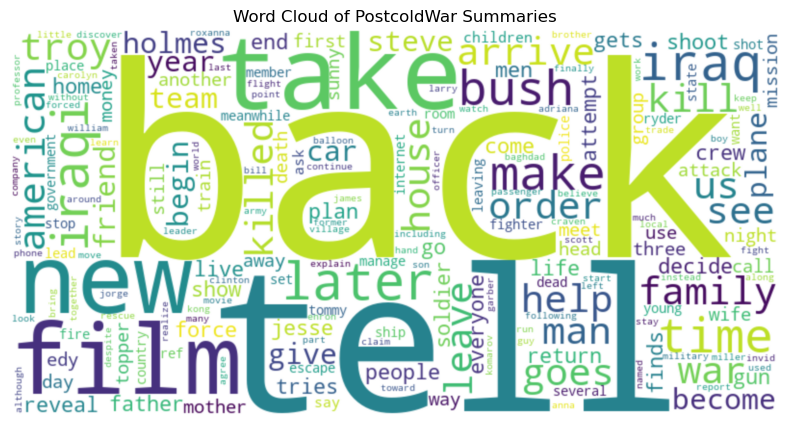

Topic 1: bush, iraqi, brothers, iraq, topper, larry, bushs, family, soldiers, kong
Topic 2: enron, slave, topper, led, jorge, william, internet, traders, ref, live
Topic 3: team, game, lynch, charlie, clinton, jesse, brown, guests, technology, edy
Topic 4: yugoslavia, jedi, nuclear, quigon, naboo, power, queen, internet, use, reveals
Topic 5: holmes, watson, lestrade, rommel, palace, hauser, balloon, flight, moran, jason
Topic 6: ted, jake, drug, tommy, iraq, trade, brendan, film, footage, government
Topic 7: trade, film, war, people, later, american, government, killed, world, home
Topic 8: miller, ryder, smiley, francisco, sykes, garber, ashley, troy, team, carolyn
Topic 9: curtis, steve, caroline, cnn, train, wiener, crew, boy, james, begin
Topic 10: sunny, james, henderson, brandon, serling, raja, walden, technology, meenakshi, president
Classified dataset saved to: /Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries_classified.csv


In [ ]:
PostColdWar = {
    "globalization": 8,
    "internet": 7,
    "y2k": 6,
    "iraq": 6,
    "genocide": 6,
    "clinton": 5,
    "bosnia": 5,
    "somalia": 5,
    "technology": 5,
    "dotcom": 4,
    "terrorism": 6,
    "peacekeeping": 4,
    "trade": 4,
    "multilateralism": 3,
    "economy": 3,
}

analyze_dataset(
    file_path="/Users/mattice/Desktop/DonDada/ada-2024-project-metal2024/data/processed_plot_summaries.csv",
    keyword_dict = PostColdWar,
    synonyms=synonyms,
    threshold=16,name="Post cold War"
)

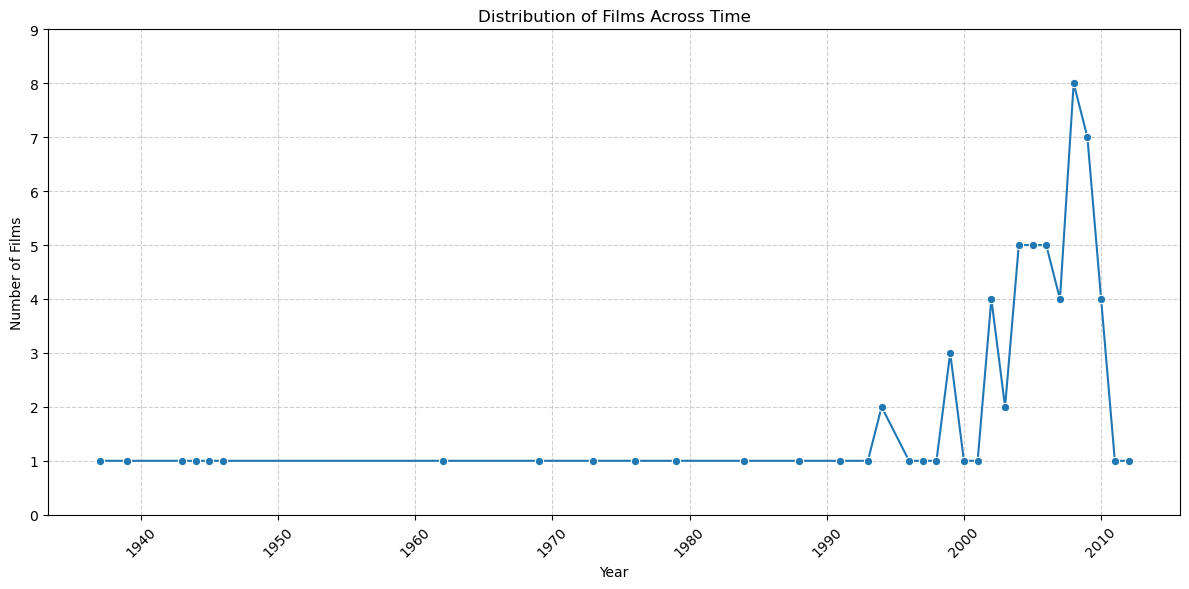

Summary statistics for film years:
count      71.000000
mean     1996.521127
std        19.383984
min      1937.000000
25%      1996.500000
50%      2004.000000
75%      2008.000000
max      2012.000000
Name: Year, dtype: float64


In [35]:
analyze_time_distribution(filtered_csv_path)